**Face Mask Detection**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d umaidalikeerio/face-mask-dataset

 89% 65.0M/73.4M [00:00<00:00, 92.6MB/s]
100% 73.4M/73.4M [00:00<00:00, 88.2MB/s]


In [ ]:
import zipfile
zip=zipfile.ZipFile("/content/face-mask-dataset.zip","r")
zip.extractall('/content')
zip.close()

**Importing Necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.14.0


In [ ]:
train_dir=Path("/content/Dataset/train/train")
train_filepaths=list(train_dir.glob(r'**/*.jpg'))

In [ ]:
test_dir=Path("/content/Dataset/test/test")
test_filepaths=list(test_dir.glob(r'**/*.jpg'))

In [ ]:
import pandas as pd

def image_processing(filepaths):
    # Ensure all filepaths are converted to strings
    filepaths = [str(filepath) for filepath in filepaths]

    # Extract labels from filepaths
    labels = [str(filepath).split("/")[-2] for filepath in filepaths]

    # Create a DataFrame with filepaths and labels
    df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [ ]:
train_df=image_processing(train_filepaths)
test_df=image_processing(test_filepaths)


In [ ]:
print("---Trainig Set---\n")
print(f"Number of Images: {train_df.shape[0]}\n")
print(f"Number of different labels: {len(train_df.Label.unique())}\n")
print(f"Labels: {train_df.Label.unique()}")

---Trainig Set---

Number of Images: 1294

Number of different labels: 2

Labels: ['with_mask' 'without_mask']


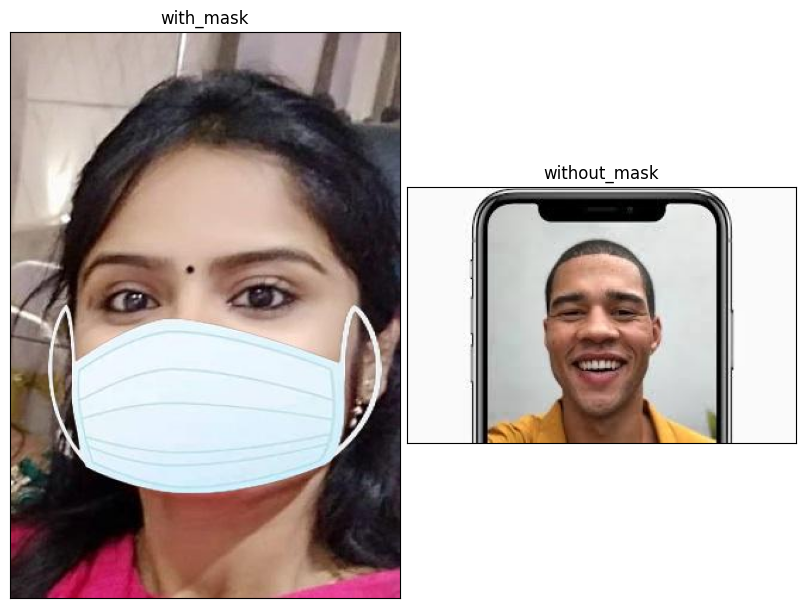

In [37]:
#Create a DataFrame with one label of each category
df_unique=train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

#Displaying Some Images of the dataset
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(8,7),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df_unique.Filepath[i]))
  ax.set_title(df_unique.Label[i],fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
#Training the image to create a new image and identify(Data Augmentation)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,  # Corrected parameter name
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


Found 1294 validated image filenames belonging to 2 classes.


In [ ]:
#Testing the image to test a new image and identify
test_images = train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0,
)


Found 194 validated image filenames belonging to 2 classes.


In [ ]:
pretrained_model=tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
)
pretrained_model.trainable=False

9406464/9406464 [==============================] - 0s 0us/step


**CNN Model**

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
inputs = pretrained_model.input

x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after a dense layer to avoid overfitting

x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after a dense layer
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after a dense layer

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)

outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x) #Binary classification

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=test_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
41/41 [==============================] - 9s 144ms/step - loss: 0.5023 - accuracy: 0.9490 - val_loss: 0.3508 - val_accuracy: 1.0000
Epoch 2/5
41/41 [==============================] - 5s 126ms/step - loss: 0.3228 - accuracy: 0.9946 - val_loss: 0.3076 - val_accuracy: 0.9948
Epoch 3/5
41/41 [==============================] - 8s 206ms/step - loss: 0.2599 - accuracy: 1.0000 - val_loss: 0.2535 - val_accuracy: 0.9948
Epoch 4/5
41/41 [==============================] - 5s 120ms/step - loss: 0.2206 - accuracy: 1.0000 - val_loss: 0.2179 - val_accuracy: 0.9948
Epoch 5/5
41/41 [==============================] - 8s 197ms/step - loss: 0.1893 - accuracy: 1.0000 - val_loss: 0.1901 - val_accuracy: 0.9948


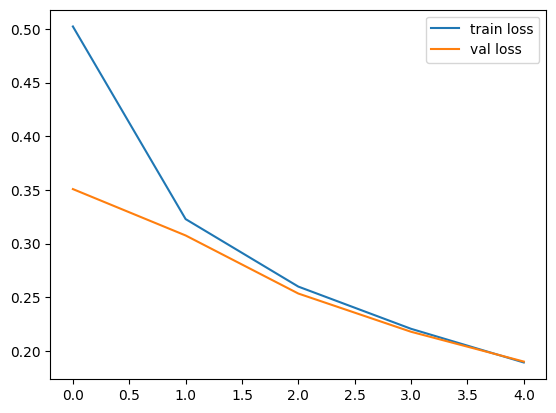

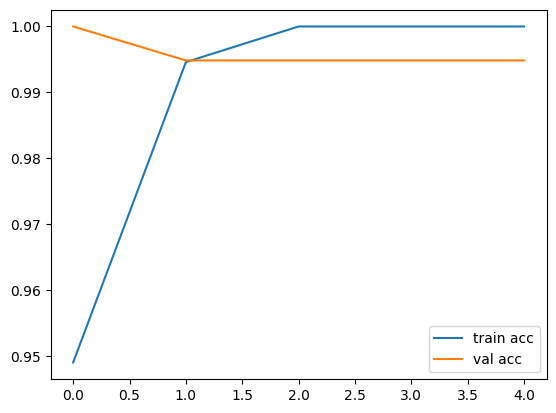

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

7/7 [==============================] - 2s 91ms/step


['without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'with_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'with_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'without_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'without_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'without_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'without_mask',

In [ ]:
def output(location):
  img=load_img(location,target_size=(224,224,3))
  img=img_to_array(img)
  img=img/255
  img=np.expand_dims(img,[0])
  answer=model.predict(img)
  y_class=answer.argmax(axis=-1)
  y=" ".join(str(x) for x in y_class)
  y=int(y)
  res=labels[y]
  return res

1/1 [==============================] - 0s 55ms/step
The person is with_mask.


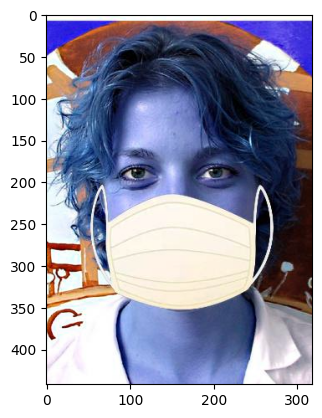

In [39]:
import numpy as np
from tensorflow.keras.preprocessing import image
import cv2

test_img= cv2.imread("/content/Dataset/test/test/with_mask/404-with-mask.jpg")
plt.imshow(test_img)

predicted_face=output("/content/Dataset/test/test/with_mask/404-with-mask.jpg")

print(f"The person is {predicted_face}.")